# 1. Model Training
This notebook performs the following tasks:
* Creates dataloaders from the data folder (see README).
* Defines and instantiates the GRL model.
* Trains the model.

At each stage, files with important information are saved to disk (dataset status, PyTorch model files/checkpoints, and logs with metrics recorded during training).

## Short goal and logic
Set up the environment for PyTorch-based (possibly distributed) deep learning, computer vision data pipelines, optimization, scheduling, plotting, and serialization. No code is executed; this cell only imports modules and names used later.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, sys, gc
import time
from datetime import datetime
import copy
import random
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, TensorDataset, DistributedSampler
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler,SGD,Adam,AdamW,Adagrad,RMSprop
from PIL import Image
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from types import resolve_bases
import pickle
from sklearn.model_selection import train_test_split
import cloudpickle
import math

## Short goal and logic
Select a compute device for PyTorch tensors and models.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Short goal and logic
Ensure experiment reproducibility by fixing random number generator (RNG) states across Python, NumPy, and PyTorch, and forcing deterministic cuDNN behavior.

In [17]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Short goal and logic
Attempt to free memory by dropping references and triggering garbage collection; clear CUDA allocator cache to release unused GPU memory back to the driver.

In [18]:
def clear_ram():
    model=None
    optimizer=None
    gc.collect()
    torch.cuda.empty_cache()
clear_ram()

## Short goal and logic
Define central configuration constants for data handling and training: image resolution, dataset location, parallelism level, and per-split batch sizes.
## Key variables and how they are used
* IMG_SIZE: Target image size for preprocessing/augmentations and model input.
* DATA_FOLDER: Root path to datasets; used to build file paths for splits.
* THREADS: Degree of parallelism for data loading/preprocessing (e.g., DataLoader num_workers or thread pools).
* BATCHES: Batch size per dataset split; consumed when constructing loaders.

In [19]:
IMG_SIZE=224
DATA_FOLDER="/MAIN/files20/"
THREADS = 16
BATCHES = {'train':4,'val':10,'gold':10}

## Short goal and logic
Build a PyTorch Dataset that yields fixed-length, per-class image sequences. It optionally restricts to a subset of indices, shuffles indices per class each epoch, chunks them into non-overlapping sequences, loads images, applies a transform, and returns [T, C, H, W] sequences concatenated with zero-padding.
## Key variables and how they are used
* root: Path passed to ImageFolder for image discovery and labeling.
* seq_len: Target sequence length T for each sample.
* allowed_idxs: Optional list of sample indices to include; otherwise uses all samples.
* transform: Callable applied to each PIL image (default transforms.ToTensor()).
* self.folder: ImageFolder instance providing samples and labels.
* self.allowed: Final list of indices to use.
* self.by_class: Dict label -> list of allowed indices, used to form per-class sequences.
* self.sequences, self.labels: Parallel lists of index-chunks and their class labels, refreshed in on_epoch_end.
## Important functions/methods
* init: Builds index groups by class and initializes sequences via on_epoch_end.
* on_epoch_end: Shuffles indices within each class and creates non-overlapping chunks of size seq_len.
* len: Number of generated sequences.
* getitem: Loads images for a chunk, applies transform, stacks to [T, C, H, W], concatenates zeros of shape [2T, C, H, W], returns (tensor, label).

Used APIs: torchvision.datasets.ImageFolder, PIL.Image.open(...).convert('RGB'), torch.stack, Tensor.permute, torch.zeros, torch.cat, random.shuffle.


In [20]:
class SequenceFolder(Dataset):
    def __init__(self, root, seq_len, allowed_idxs=None, transform=None):
        self.folder     = ImageFolder(root)
        self.transform  = transform or transforms.ToTensor()
        self.seq_len    = seq_len

        # если передан список разрешённых изображений — используем его, иначе все сразу
        self.allowed = allowed_idxs or list(range(len(self.folder.samples)))

        # группируем разрешённые индексы по классам
        self.by_class = {}
        for i in self.allowed:
            _, label = self.folder.samples[i]
            self.by_class.setdefault(label, []).append(i)

        # initial fill
        self.on_epoch_end()

    def on_epoch_end(self):
        self.sequences = []
        self.labels    = []
        for label, idxs in self.by_class.items():
            random.shuffle(idxs)
            for i in range(0, len(idxs) - self.seq_len + 1, self.seq_len):
                chunk = idxs[i : i + self.seq_len]
                self.sequences.append(chunk)
                self.labels.append(label)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        chunk = self.sequences[idx]
        imgs  = []
        for i in chunk:
            path, _ = self.folder.samples[i]
            img = Image.open(path).convert('RGB')
            imgs.append(self.transform(img))       
        zeros =  torch.zeros((len(imgs)*2, ) + imgs[0].shape)
        zeros.permute(1,0,2,3)
        seq = torch.stack(imgs, dim=1).permute(1,0,2,3)  # [T, C, H, W]
        return torch.cat((seq, zeros), dim=0), self.labels[idx]

## Short goal and logic
Build train/val/gold splits from an ImageFolder, wrap them with SequenceFolder using a given seq_len and transforms, optionally attach DistributedSamplers, create DataLoaders, persist a small “state” snapshot, and return loaders, sizes, and class names.
## Key variables and how they are used
* seq_len: Sequence length passed to each SequenceFolder.
* sampler, world_size, rank: Enable and parameterize DistributedSampler for DDP.
* Externals: DATA_FOLDER (dataset root), IMG_SIZE (resize/crop target), THREADS (num_workers), BATCHES (per-split batch sizes).
* data_transforms: Per-split transforms (Resize -> CenterCrop -> ToTensor -> Normalize).
* train_idxs, val_idxs, gold_idxs: Stratified split for val; further split of train into gold (not stratified).
* image_datasets: Dict of SequenceFolder datasets for train/val/gold.
* samplers: Dict of DistributedSampler objects when sampler=True.
* dataloaders: Dict of DataLoader per split (with sampler or shuffle).
* dataset_sizes: Number of sequences per split (len of SequenceFolder), not images.
* class_names: Folder class list from ImageFolder.

In [21]:
def get_loaders(seq_len=None,sampler=False, world_size=None, rank=None):
    batches=BATCHES
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }
    # 1. We get all indexes and their labels
    full_folder = ImageFolder(DATA_FOLDER)
    all_idxs   = list(range(len(full_folder.samples)))
    all_labels = [label for _, label in full_folder.samples]
    
    # 2. We split them stratified into train/val/gold
    train_idxs, val_idxs = train_test_split(
        all_idxs,
        test_size=0.2,
        stratify=all_labels,
        random_state=42
    )
    train_idxs, gold_idxs = train_test_split(
        train_idxs,
        test_size=0.1,
        # stratify=all_labels,
        random_state=42
    )
    
    # 3. We create three datasets and three dataloaders
    image_datasets= {
        'train': SequenceFolder(DATA_FOLDER, seq_len,
                              allowed_idxs=train_idxs,
                              transform=data_transforms['train']),
        'val': SequenceFolder(DATA_FOLDER, seq_len,
                              allowed_idxs=val_idxs,
                              transform=data_transforms['val']),
        'gold': SequenceFolder(DATA_FOLDER, seq_len,
                              allowed_idxs=gold_idxs,
                              transform=data_transforms['val'])
    }
    class_names =image_datasets['train'].folder.classes
    state = {
        'train_idxs':  image_datasets["train"].allowed,
        'val_idxs':    image_datasets["val"].allowed,
        'gold_idxs':   image_datasets["gold"].allowed,
        'seq_len':     seq_len,
        'glob_pool':  -1 if 'GLOB_POOL' not in vars()  else GLOB_POOL,
        'img_size':    IMG_SIZE,
        'train_data_transforms': image_datasets["train"].transform,
        'val_data_transforms': image_datasets["val"].transform,
        'gold_data_transforms': image_datasets["gold"].transform,
        'class_names': class_names,
    }
    if sampler:
        samplers = image_datasets= {
            'train': DistributedSampler(image_datasets['train'], num_replicas=world_size, rank=rank),
            'val': DistributedSampler(image_datasets['val'], num_replicas=world_size, rank=rank),
            'gold': DistributedSampler(image_datasets['gold'], num_replicas=world_size, rank=rank)
        }
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size= batches['train'], shuffle=False,  num_workers=THREADS, sampler=samplers['train']),
            'val': DataLoader(image_datasets['val'],   batch_size= batches['val'] , shuffle=False, num_workers=THREADS, sampler=samplers['val']),
            'gold': DataLoader(image_datasets['gold'],   batch_size= batches['gold'] , shuffle=False, num_workers=THREADS, sampler=samplers['gold']),
            }
    else:
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size= batches['train'], shuffle=True,  num_workers=THREADS),
            'val': DataLoader(image_datasets['val'],   batch_size= batches['val'] , shuffle=True, num_workers=THREADS),
            'gold': DataLoader(image_datasets['gold'],   batch_size= batches['gold'] , shuffle=True, num_workers=THREADS),
            }
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','gold']}
    
    # 4. Save parameters to a file for subsequent idempotent recovery
    d = datetime.now()
    with open(f'rnn_conv_ds_{d.hour:02d}.{d.minute:02d}.{d.second:02d}.pkl', 'wb') as file:
        cloudpickle.dump(state, file)
    
    return dataloaders, dataset_sizes, class_names
    d = datetime.now()
    with open(f'rnn_conv_ds_{d.hour:02d}.{d.minute:02d}.{d.second:02d}.pkl', 'wb') as file:
        cloudpickle.dump(state, file)
    return dataloaders,dataset_sizes,class_names
dataloaders, dataset_sizes, class_names = get_loaders(seq_len=5)

## Short goal and logic
Implement a single ConvLSTM cell: concatenates current input and previous hidden state, applies one 2D conv to produce all four gate tensors, normalizes and drops them out, computes LSTM-style gates (i,f,g,o), and returns updated hidden (h) and cell (c) states with the same spatial size.
## Key variables and how they are used
* in_channels: Channels of input x.
* hidden_channels: Size of hidden state h and cell state c; also determines gate channel splits.
* kernel_size: Convolution kernel; padding = kernel_size // 2 for “same” spatial size with odd kernels.
* self.conv: Single conv producing 4*hidden_channels outputs for the four gates from [x; h_prev].
* self.norm: GroupNorm(32, 4*hidden_channels) applied to conv output.
* self.dropout: Dropout2d(p=0.1) applied after normalization.
* Gate bias init: self.conv.bias[self.hidden_channels:2*self.hidden_channels] = -1.0 sets forget-gate bias to -1.
Important functions/methods
* init: Builds convolution, initializes forget-gate bias, sets normalization and dropout.
* forward(x, hidden): x [B, Cin, H, W], hidden=(h_prev, c_prev) each [B, hidden, H, W]; computes gates via conv→norm→dropout, splits into (i,f,g,o), updates c and h, returns (h, c).


In [22]:
class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, bias=True):
        super().__init__()
        self.hidden_channels = hidden_channels
        padding = kernel_size // 2
        # объединяем все 4 свёртки в одну с выходными каналами 4*hidden
        self.conv = nn.Conv2d(
            in_channels + hidden_channels,
            4 * hidden_channels,
            kernel_size,
            padding=padding,
            bias=bias
        )
        nn.init.constant_(self.conv.bias[self.hidden_channels:2*self.hidden_channels], -1.0)
        self.norm = nn.GroupNorm(32, 4 * hidden_channels)
        self.dropout = nn.Dropout2d(0.1)
        self.hidden_channels = hidden_channels

    def forward(self, x, hidden):
        h_prev, c_prev = hidden  # каждое: [B, hidden_channels, H, W]
        # конкатенация по каналам
        combined = torch.cat([x, h_prev], dim=1)
        conv_out = self.dropout(self.norm(self.conv(combined)))
        
        # разделим выход на 4 части
        cc_i, cc_f, cc_g, cc_o = torch.split(conv_out, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        g = torch.tanh(cc_g)
        o = torch.sigmoid(cc_o)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

## Short goal and logic
Build an image-sequence classifier using stacked ConvLSTM cells. Each time step is processed through all ConvLSTM layers with spatial downsampling (MaxPool) between layers; the last layer’s final hidden state is globally pooled and fed to a linear classifier.
## Key variables and how they are used
* in_channels: Channels of input frames.
* hidden_channels: List defining number of channels per ConvLSTM layer; also sets number of layers (len(hidden_channels)).
* kernel_size: Spatial kernel for each ConvLSTMCell.
* num_classes: Output dimension of the classifier head; default depends on external class_names.
* glob_pool: Target output size for AdaptiveAvgPool2d; used to compute flattened feature size N = hidden_channels[-1] * glob_pool^2.
* seq_len_train: Stored but not used in forward; intended for training-time logic.
* self.cells: Stack of ConvLSTMCell layers.
* self.maxpool: 2x2 spatial downsampling between ConvLSTM layers.
* self.global_pool: Adaptive average pooling to glob_pool x glob_pool.
* self.fc: Final linear layer mapping pooled features to logits.
* self.trans: Data augmentation pipeline used by prep_batch.
## Important functions/methods
* init: Builds ConvLSTM stack, pooling, global pooling, linear head, and augmentation pipeline.
* forward(x_seq): Expects [B, T, C, H, W]; initializes zero states per layer (with halved H/W per deeper layer), iterates over time, updates ConvLSTM states layer-by-layer with MaxPool between layers, then pools h from the top layer at the last time step and classifies.
* prep_batch(inputs): In-place augmentation utility; for each item, picks one “template” frame index t among the first n = T//3 frames and replaces other frames in that range with augmented copies of frame t.

In [23]:
class ConvLSTMClassifier(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=[32, 64, 128], 
                 kernel_size=3, num_classes=len(class_names), seq_len_train=None , glob_pool=None):
        super().__init__()
        self.seq_len_train=seq_len_train
        self.num_layers = len(hidden_channels)
        self.cells = nn.ModuleList()
        prev_channels = in_channels
        for h_ch in hidden_channels:
            self.cells.append(ConvLSTMCell(prev_channels, h_ch, kernel_size))
            prev_channels = h_ch
        self.maxpool= nn.MaxPool2d(2)

        # после последнего скрытого состояния — глобальный пулинг и FC
        self.global_pool = nn.AdaptiveAvgPool2d(glob_pool)
        N = hidden_channels[-1]*glob_pool**2
        # self.fc = nn.Sequential(nn.Linear(N, num_classes*2),nn.BatchNorm1d(num_classes*2),nn.ELU(), nn.Dropout(0.1),nn.Linear(num_classes*2,num_classes))
        self.fc = nn.Linear(N, num_classes)
        self.trans = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=.05, hue=0.03),    # hue=.05
            transforms.RandomRotation((-20,20),interpolation=transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
        ])

    def forward(self, x_seq):
        """
        x_seq: тензор [B, T, C, H, W]
        """
        B, T, C, H, W = x_seq.shape
        # инициализируем состояния нулями
        h = []
        H_=H
        W_=W
        for ch in [cell.hidden_channels for cell in self.cells]:
            h.append(torch.zeros(B, ch, H_, W_, device=x_seq.device))
            H_ //=2
            W_ //=2
        c = [torch.zeros_like(h_i) for h_i in h]

        # разбиваем последовательность по шагам
        for t in range(T):
            x = x_seq[:, t]  # [B, C, H, W]
            for l, cell in enumerate(self.cells):
                h[l], c[l] = cell(x, (h[l], c[l]))
                x = self.maxpool(h[l])  # вход для следующего слоя

        # берем последнее скрытое состояние верхнего слоя
        out = self.global_pool(h[-1]).view(B, -1)  # [B, hidden]
        logits = self.fc(out)  # [B, num_classes]
        return logits

    def prep_batch(self, inputs):
        for b in range(len(inputs)):
            n = inputs[b].shape[0]//3
            t = random.randint(0, n-1)
            for i in range(n):
                if i==t: continue
                inputs[b][i] = self.trans(torch.clone(inputs[b][t]))
                # inputs[b][i] = torch.clone(inputs[b][t])

## Short goal and logic
Learning-rate scheduler like ReduceLROnPlateau with simple moving-average (SMA) smoothing. After a warmup (start_epoch) and once enough points are collected (window_size), it tracks the best smoothed metric and reduces LR by factor when no improvement is seen for patience windows. Resets counters after each LR drop.
## Key variables and how they are used
* optimizer: Torch optimizer whose param_groups’ lr will be updated.
* factor: Multiplicative decay (new_lr = max(old_lr * factor, min_lr)).
* patience: Number of consecutive non-improving smoothed windows before decay.
* start_epoch: 1-based epoch gate before the scheduler starts reacting.
* window_size: Length of SMA; uses the last window_size losses to compute smoothed.
* min_lr: Lower LR bound applied per param group.
* mode: 'min' for loss-like metrics, 'max' for score-like metrics.
* loss_history, best_smoothed, num_bad_epochs: Internal state for smoothing, best value tracking, and patience.
## Important functions/methods
* init(...): Stores config and initializes state.
* step(epoch, current_loss): Append metric, enforce warmup and windowing, compute smoothed = mean(last window_size), update best and bad-epoch counter per mode, decay all param groups when patience is exceeded, then reset best_smoothed to current smoothed and num_bad_epochs to 0. Verbose prints LR changes.

In [24]:
class SmoothedReduceLROnPlateau:
    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 factor: float = 0.5,
                 patience: int = 7,
                 start_epoch: int = 10,
                 window_size: int = 7,
                 min_lr: float = 1e-5,
                 verbose: bool = True,
                 mode: str = 'min'):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.start_epoch = start_epoch
        self.window_size = window_size
        self.min_lr = min_lr
        self.verbose = verbose
        self.mode = mode

        self.loss_history = []
        self.best_smoothed = None
        self.num_bad_epochs = 0

    def step(self, epoch: int, current_loss: float):
        """
        Вызывать в конце каждой эпохи:
            scheduler.step(epoch, loss)
        """
        self.loss_history.append(current_loss)

        # Ждём до стартовой эпохи
        if epoch + 1 < self.start_epoch:
            return

        # Если ещё не накопили окно — ждём
        if len(self.loss_history) < self.window_size:
            return

        # Вычисляем SMA последних window_size значений
        window = self.loss_history[-self.window_size:]
        smoothed = sum(window) / self.window_size

        # Инициализация best_smoothed при первом измерении
        if self.best_smoothed is None:
            self.best_smoothed = smoothed
            self.num_bad_epochs = 0
            return

        # Проверяем, было ли улучшение
        if (self.mode == 'min' and smoothed < self.best_smoothed) or \
           (self.mode == 'max' and smoothed > self.best_smoothed):
            self.best_smoothed = smoothed
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        # Если терпение исчерпано — снижаем LR
        if self.num_bad_epochs >= self.patience:
            for i, param_group in enumerate(self.optimizer.param_groups):
                old_lr = param_group['lr']
                new_lr = max(old_lr * self.factor, self.min_lr)
                if new_lr < old_lr:
                    param_group['lr'] = new_lr
                    if self.verbose:
                        print(
                            f"[Epoch {epoch+1}] "
                            f"SmoothedReduceLROnPlateau: "
                            f"lr[{i}] {old_lr:.6f} → {new_lr:.6f}"
                        )
            # Сбросим счётчики
            self.best_smoothed = smoothed
            self.num_bad_epochs = 0


## Short goal and logic
Train/evaluate a model across epochs over three phases ('train', 'val', 'gold'), track metrics, apply optional batch augmentation via model.prep_batch, update optimizer and a custom scheduler on the 'gold' phase, plot histories each epoch, checkpoint to disk, and finally restore best weights (by lowest val loss) and return artifacts.
## Key variables and how they are used
* model, criterion, optimizer, scheduler: Core training components; optimizer stepped only in 'train'; scheduler stepped once per epoch using 'gold' loss.
num_epochs, device: Training length and tensor device; inputs/labels moved to device each batch.
* dataloaders, dataset_sizes (globals): Provide batches and dataset sizes for phases; sizes used to average loss/accuracy.
* best_model_wts, best_loss, best_acc, best_epoch: Track best checkpoint by validation loss.
* hist_* lists: Per-epoch history for loss/accuracy in train/val/gold; persisted to .pkl every epoch and returned (train/val only at the end).
* cnt: Batch counter (unused for logic).
* fig: Matplotlib figure reference from the last epoch’s plotting; returned.

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = []
    hist_loss_val = []; hist_acc_val = []
    hist_loss_gold = []; hist_acc_gold = []

    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        for phase in ['train', 'val', 'gold']:
            torch.cuda.empty_cache()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = running_corrects = 0
            # Iterate over data.
            cnt=0
            for inputs, labels in dataloaders[phase]:
                cnt += len(labels)
                if phase == 'train' and random.random() < 0.5:
                    model.prep_batch(inputs)
                if phase == 'gold':
                    model.prep_batch(inputs)
                # with open("rnn_counters.txt", "w") as f:
                #     f.write(f"{epoch}_{cnt}")
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'gold':
                scheduler.step(epoch, epoch_loss)
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #     phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(float(epoch_loss))
                hist_acc_train.append(float(epoch_acc.cpu()))
            elif phase == 'val':
                hist_loss_val.append(float(epoch_loss))
                hist_acc_val.append(float(epoch_acc.cpu()))
            else:
                hist_loss_gold.append(float(epoch_loss))
                hist_acc_gold.append(float(epoch_acc.cpu()))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = float(epoch_acc.cpu())
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            dataloaders[phase].dataset.on_epoch_end()
        # print()
        clear_output(True)
        print(f"epoch:{epoch} time:{(time.time() - since)/(epoch+1):.1f} acc:{hist_acc_val[-1]:.4f}")
        fig=plt.figure()
        plt.plot(np.arange(0,epoch+1),hist_loss_train,label='hist_loss_train')
        plt.plot(np.arange(0,epoch+1),hist_loss_val,label='hist_loss_val')
        plt.plot(np.arange(0,epoch+1),hist_loss_gold,label='hist_loss_gold')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Loss')
        plt.show()
        plt.plot(np.arange(0,epoch+1),hist_acc_train,label='hist_acc_train')
        plt.plot(np.arange(0,epoch+1),hist_acc_val,label='hist_acc_val')
        plt.plot(np.arange(0,epoch+1),hist_acc_gold,label='hist_acc_gold')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Acc')
        plt.show()
        d = datetime.now()
        torch.save(model, f'rnn_conv_{d.hour:02d}.{d.minute:02d}.{d.second:02d}.pth')
        dict_hist={
            "hist_loss_train": hist_loss_train,
            "hist_acc_train": hist_acc_train,
            "hist_loss_val": hist_loss_val,
            "hist_acc_val": hist_acc_val,
            "hist_loss_gold": hist_loss_gold,
            "hist_acc_gold": hist_acc_gold
        }
        with open(f'rnn_conv_report_{d.hour:02d}.{d.minute:02d}.{d.second:02d}.pkl', 'wb') as file:
            pickle.dump(dict_hist, file)
        
        dict_hist=None
        
    model.eval()
    time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(
    #     time_elapsed // 60, time_elapsed % 60))
    # print('Best epoch:{} val Loss:{:4f} Acc: {:4f}'.format(best_epoch,best_loss,best_acc))
    
    dict_hist={
        "hist_loss_train": hist_loss_train,
        "hist_acc_train": hist_acc_train,
        "hist_loss_val": hist_loss_val,
        "hist_acc_val": hist_acc_val
    }
    # load best model weights
    model.load_state_dict(best_model_wts)
    model.eval()
    return model,best_acc,time_elapsed,fig,dict_hist

## Short goal and logic
In the cell below, you’ll find the code that restores the dataloaders to the exact state they had during training. If you want to reproduce our experiment exactly, uncomment the code below.
## Key variables and how they are used
* batches (alias BATCHES): dict with per-phase batch sizes; used to configure DataLoader batch_size.
* DATA_FOLDER: root path of the data; passed to SequenceFolder.
* state: deserialized configuration holding splits and transforms.
* train_idxs, val_idxs, gold_idxs: indices to include per split; fed to SequenceFolder via allowed_idxs.
* SEQ_LEN: sequence length for samples; passed to SequenceFolder.
* IMG_SIZE: image size (loaded but not used here; likely used elsewhere).
* data_transforms: per-phase transforms restored from state; passed to SequenceFolder.
* class_names: label names (loaded for reference/use elsewhere).
* image_datasets: dict of SequenceFolder instances for each phase.
* dataloaders: dict of torch.utils.data.DataLoader per phase with shuffle=True and num_workers=10.
* dataset_sizes: lengths of datasets, used for metric normalization downstream.

In [28]:
# batches=BATCHES 
# # 1) Загружаем состояние
# with open('rnn_conv_ds_08.12.54.pkl', 'rb') as f:
#     state = cloudpickle.load(f)

# # 2) Вытаскиваем всё
# train_idxs = state['train_idxs']
# val_idxs = state['val_idxs']
# gold_idxs = state['gold_idxs']
# SEQ_LEN  = state['seq_len']
# IMG_SIZE = state['img_size']
# data_transforms = {"train":state['train_data_transforms'],
#     "val": state['val_data_transforms'],
#     "gold": state['gold_data_transforms'],
#       }
# class_names     = state['class_names']

# # 3) Реконструируем DataLoader’ы «на лету»
# image_datasets= {
#     'train': SequenceFolder(DATA_FOLDER, SEQ_LEN,
#                           allowed_idxs=train_idxs,
#                           transform=data_transforms['train']),
#     'val': SequenceFolder(DATA_FOLDER, SEQ_LEN,
#                           allowed_idxs=val_idxs,
#                           transform=data_transforms['val']),
#     'gold': SequenceFolder(DATA_FOLDER, SEQ_LEN,
#                           allowed_idxs=gold_idxs,
#                           transform=data_transforms['gold'])
# }

# dataloaders = {
#     'train': DataLoader(image_datasets['train'], batch_size= batches['train'], shuffle=True,  num_workers=10),
#     'val': DataLoader(image_datasets['val'],   batch_size= batches['val'] , shuffle=True, num_workers=10),
#     'gold': DataLoader(image_datasets['gold'],   batch_size= batches['gold'] , shuffle=True, num_workers=10),
#     }
# dataset_sizes = { 'train': len(image_datasets['train']), 'val': len(image_datasets["val"]) , 'gold': len(image_datasets["gold"])}

## Short goal and logic
Launch a single training worker, optionally under Distributed Data Parallel (DDP). For each hyperparameter combo, it seeds deterministically, builds loaders/model/optimizer/scheduler, trains with train_model, logs the best result to a pickle file, and frees memory.
## Key variables and how they are used
* rank, world_size, ddp: DDP process identity and toggle; used to set env vars and initialize the process group.
* device: Training device; CUDA if available (DDP path uses cuda only for rank 0 as written), otherwise CPU.
* check_in_log/save_to_log: Read/append tuples (params, best_acc, time_elapsed) in data.pkl to skip repeated runs and record outcomes.
* greed, params, combos: Hyperparameter grid (hidden_ch, glob_pool, seq_len) and current selection.
* dataloaders, dataset_sizes, class_names: From get_loaders; drive training and metrics; class_names sets num_classes.
* model: ConvLSTMClassifier configured by params; wrapped in DDP when ddp=True.
* criterion, param_groups, optimizer: Cross-entropy loss; AdamW with weight decay only on non-bias params.
* scheduler: SmoothedReduceLROnPlateau to reduce LR on plateau (factor 0.7, patience 9, start_epoch 15, window 70, min_lr 1e-4).
* best_acc, time_elapsed: Returned from train_model and logged.
* accuracy_all, times_all, params_all: Accumulate run summaries (not returned).

In [ ]:
def worker(rank, world_size, ddp=False):
    if ddp:
        os.environ["MASTER_ADDR"] = "localhost"
        os.environ["MASTER_PORT"] = "12355"
        os.environ["RANK"] = str(rank)
        os.environ["WORLD_SIZE"] = str(world_size)
        print(f"Running DDP worker {rank} / {world_size}")
        dist.init_process_group("gloo", rank=rank, world_size=world_size)
        device = torch.device(f"cuda:{rank}" if torch.cuda.is_available() and rank == 0 else "cpu")
        print(f"     {rank}   {device}")
    else: 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def check_in_log(d):
        try:
            with open('data.pkl', 'rb') as file:
                res = pickle.load(file)
                for r in res:
                    if r[0]==d:
                        return True
        except:
            pass
        return False
    
    def save_to_log(d,a,t):
        try:
            with open('data.pkl', 'rb') as file:
                res = pickle.load(file)
                res.append((d,a,t))
        except:
            res = [(d,a,t)]
        with open('data.pkl', 'wb') as file:
            pickle.dump(res, file)
    
    hidden_ch = [[32,64,128,256]]
    glob_pool=[2]
    seq_len=[10]
    import itertools
    # Параметры модели
    greed={"hidden_ch":hidden_ch,"glob_pool":glob_pool,"seq_len":seq_len}
    params_all=[]
    accuracy_all=[]
    times_all = []
    for combo in itertools.product(*greed.values()):
        seed=42
        os.environ['PYTHONHASHSEED'] = str(seed)
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8"  # если CUDA ≥10.2
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True, warn_only=True)
        # Создаём словарь параметров, сопоставляя каждое имя ключу
        params = dict(zip(greed.keys(), combo))
        if check_in_log(params):
            continue
        print(params)
        params_all.append(params)
        GLOB_POOL=params["glob_pool"]
        dataloaders, dataset_sizes, class_names = get_loaders(seq_len=params["seq_len"],sampler=ddp)
        model = ConvLSTMClassifier(in_channels=3,
                                   hidden_channels=params["hidden_ch"],
                                   kernel_size=3,
                                   num_classes=len(class_names),
                                   seq_len_train=params["seq_len"] , 
                                   glob_pool=params["glob_pool"]).to(device)
        if ddp:
            model = DDP(model, device_ids=[rank]) if device.type == 'cuda' else DDP(model)
        else:
            model = model.to(device)    
        criterion = nn.CrossEntropyLoss()
        param_groups = [
            { 'params': [p for n,p in model.named_parameters() if 'bias' not in n],
              'weight_decay': 1e-2 },
            { 'params': [p for n,p in model.named_parameters() if 'bias'   in n],
              'weight_decay': 0    },
        ]
        optimizer = torch.optim.AdamW(param_groups, lr=1e-3)
        scheduler = SmoothedReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.7,
            patience=9,
            start_epoch=15,
            window_size=70,
            min_lr=1e-4,
            verbose=True,
            mode='min'
        )  
        model,best_acc,time_elapsed,fig,dict_hist = train_model(model, criterion, optimizer, scheduler, num_epochs=200, device = device)
        print(best_acc)
        accuracy_all.append(best_acc)
        times_all.append(time_elapsed)
        save_to_log(params,best_acc,time_elapsed)
        model=None
        optimizer=None
        gc.collect()
        torch.cuda.empty_cache() 

## Short goal and logic
Launch training on one computer device.

epoch:18 time:816.0 acc:0.7544


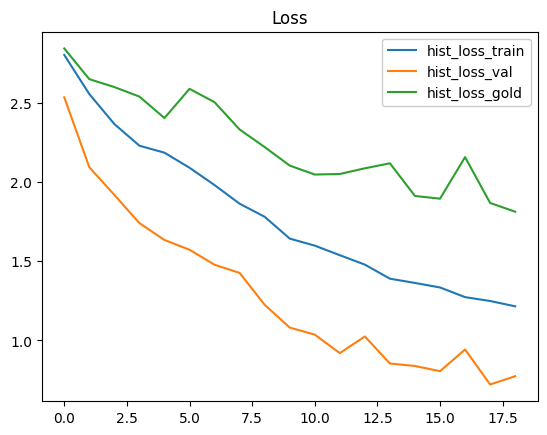

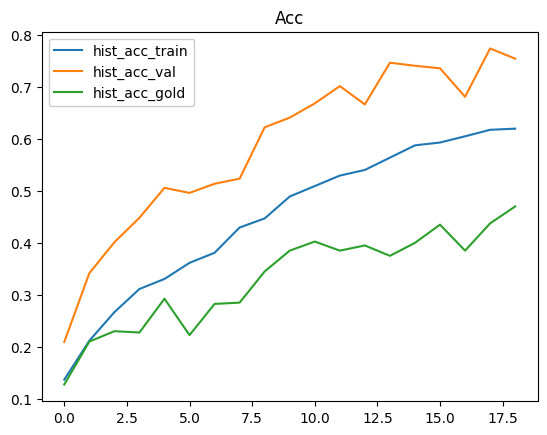

KeyboardInterrupt: 

In [16]:
worker(1,1)